# Stock Price Prediction Using RNNs

## Objective
The objective of this assignment is to try and predict the stock prices using historical data from four companies IBM (IBM), Google (GOOGL), Amazon (AMZN), and Microsoft (MSFT).

We use four different companies because they belong to the same sector: Technology. Using data from all four companies may improve the performance of the model. This way, we can capture the broader market sentiment.

The problem statement for this assignment can be summarised as follows:

> Given the stock prices of Amazon, Google, IBM, and Microsoft for a set number of days, predict the stock price of these companies after that window.

## Business Value

Data related to stock markets lends itself well to modeling using RNNs due to its sequential nature. We can keep track of opening prices, closing prices, highest prices, and so on for a long period of time as these values are generated every working day. The patterns observed in this data can then be used to predict the future direction in which stock prices are expected to move. Analyzing this data can be interesting in itself, but it also has a financial incentive as accurate predictions can lead to massive profits.

### **Data Description**

You have been provided with four CSV files corresponding to four stocks: AMZN, GOOGL, IBM, and MSFT. The files contain historical data that were gathered from the websites of the stock markets where these companies are listed: NYSE and NASDAQ. The columns in all four files are identical. Let's take a look at them:

- `Date`: The values in this column specify the date on which the values were recorded. In all four files, the dates range from Jaunary 1, 2006 to January 1, 2018.

- `Open`: The values in this column specify the stock price on a given date when the stock market opens.

- `High`: The values in this column specify the highest stock price achieved by a stock on a given date.

- `Low`: The values in this column specify the lowest stock price achieved by a stock on a given date.

- `Close`: The values in this column specify the stock price on a given date when the stock market closes.

- `Volume`: The values in this column specify the total number of shares traded on a given date.

- `Name`: This column gives the official name of the stock as used in the stock market.

There are 3019 records in each data set. The file names are of the format `\<company_name>_stock_data.csv`.

## **1 Data Loading and Preparation** <font color =red> [25 marks] </font>

#### **Import Necessary Libraries**

In [7]:
# Import libraries
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import os
import seaborn as sns



### **1.1 Data Aggregation** <font color =red> [7 marks] </font>

As we are using the stock data for four different companies, we need to create a new DataFrame that contains the combined data from all four data frames. We will create a function that takes in a list of the file names for the four CSV files, and returns a single data frame. This function performs the following tasks:
- Extract stock names from file names
- Read the CSV files as data frames
- Append the stock names into the columns of their respective data frames
- Drop unnecessary columns
- Join the data frames into one.

#### **1.1.1** <font color =red> [5 marks] </font>
Create the function to join DataFrames and use it to combine the four datasets.

In [11]:
# Define a function to load data and aggregate them
import os
import pandas as pd

def load_and_combine_stock_data(folder_path):

    df_list = []
    
    files = [f for f in os.listdir(folder_path) if f.endswith(".csv")]
    
    if not files:
        raise FileNotFoundError(f"No CSV files found in {folder_path}")
    
    for file in files:
        file_path = os.path.join(folder_path, file)   
        stock_name = file.split("_")[0]              
        
      
        df = pd.read_csv(file_path)
        
        df["Name"] = stock_name
        df_list.append(df)
    
    combined_df = pd.concat(df_list, ignore_index=True)
    return combined_df



In [12]:
print(os.getcwd())

/Users/bhuvanshree/Downloads/RNN_Stock_Starter_Dataset


In [13]:
# Specify the names of the raw data files to be read and use the aggregation function to read the files


file_list = [
    "AMZN_stock_data.csv",
    "GOOGL_stock_data.csv",
    "IBM_stock_data.csv",
    "MSFT_stock_data.csv"
]
folder_path = "RNN_Stocks_Data"


combined_data = load_and_combine_stock_data(folder_path)


print(combined_data.head())
print("\nStocks in dataset:", combined_data["Name"].unique())
print("\nShape:", combined_data.shape)

         Date   Open   High    Low  Close   Volume  Name
0  2006-01-03  47.47  47.85  46.25  47.58  7582127  AMZN
1  2006-01-04  47.48  47.73  46.69  47.25  7440914  AMZN
2  2006-01-05  47.16  48.20  47.11  47.65  5417258  AMZN
3  2006-01-06  47.97  48.58  47.32  47.87  6154285  AMZN
4  2006-01-09  46.55  47.10  46.40  47.08  8945056  AMZN

Stocks in dataset: ['AMZN' 'IBM' 'MSFT' 'GOOGL']

Shape: (12077, 7)


In [14]:
# View specifics of the data

print("Sample data:\n", combined_data.head(10))

print("\nShape of dataset:", combined_data.shape)

print("\nInfo:")
print(combined_data.info())

print("\nSummary statistics:\n", combined_data.describe())

print("\nMissing values per column:\n", combined_data.isnull().sum())

print("\nUnique stock names:", combined_data['Name'].unique())

print("\nDate range:", combined_data['Date'].min(), "to", combined_data['Date'].max())


Sample data:
          Date   Open   High    Low  Close   Volume  Name
0  2006-01-03  47.47  47.85  46.25  47.58  7582127  AMZN
1  2006-01-04  47.48  47.73  46.69  47.25  7440914  AMZN
2  2006-01-05  47.16  48.20  47.11  47.65  5417258  AMZN
3  2006-01-06  47.97  48.58  47.32  47.87  6154285  AMZN
4  2006-01-09  46.55  47.10  46.40  47.08  8945056  AMZN
5  2006-01-10  46.41  46.75  45.36  45.65  9686957  AMZN
6  2006-01-11  45.65  45.70  44.26  44.93  8497383  AMZN
7  2006-01-12  44.79  45.09  44.09  44.36  5818301  AMZN
8  2006-01-13  44.48  44.85  44.00  44.40  4432237  AMZN
9  2006-01-17  43.95  44.32  43.66  44.00  5635225  AMZN

Shape of dataset: (12077, 7)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12077 entries, 0 to 12076
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    12077 non-null  object 
 1   Open    12076 non-null  float64
 2   High    12077 non-null  float64
 3   Low     12076 non-null  

#### **1.1.2** <font color =red> [2 marks] </font>
Identify and handle any missing values.

In [16]:
# Handle Missing Values
print( combined_data.isnull().sum())


Date      0
Open      1
High      0
Low       1
Close     0
Volume    0
Name      0
dtype: int64


In [17]:
combined_data = combined_data.dropna()

print( combined_data.isnull().sum())
print( combined_data.shape)

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
Name      0
dtype: int64
(12076, 7)


### **1.2 Analysis and Visualisation** <font color =red> [5 marks] </font>

#### **1.2.1** <font color =red> [2 marks] </font>
Analyse the frequency distribution of stock volumes of the companies and also see how the volumes vary over time.

In [20]:
print(combined_data.columns)


Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Name'], dtype='object')


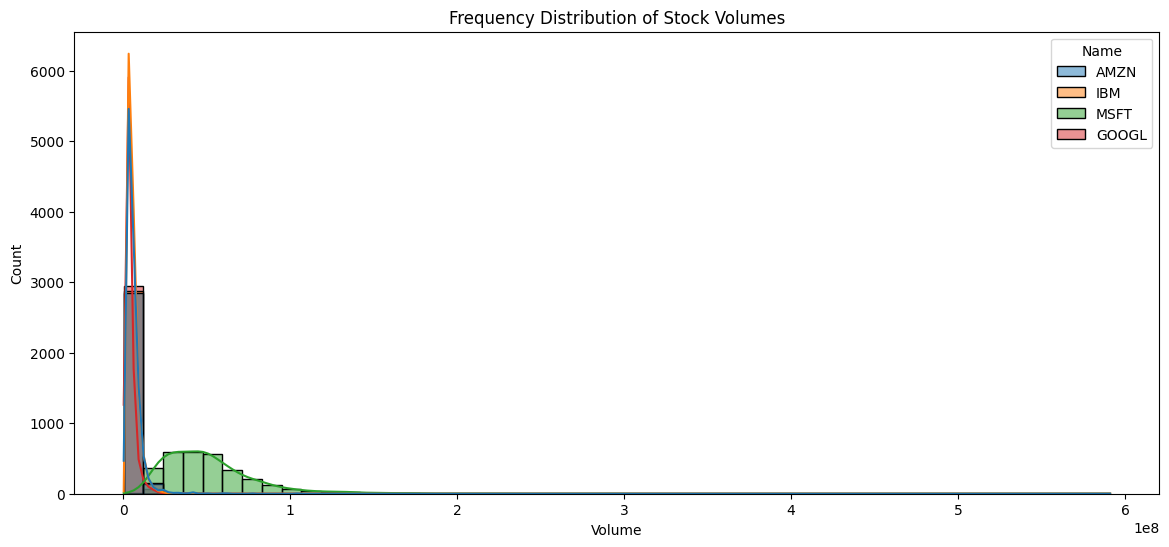

In [21]:
# Frequency distribution of volumes
plt.figure(figsize=(14,6))
sns.histplot(data=combined_data, x="Volume", hue="Name", bins=50, kde=True)
plt.title("Frequency Distribution of Stock Volumes")
plt.show()


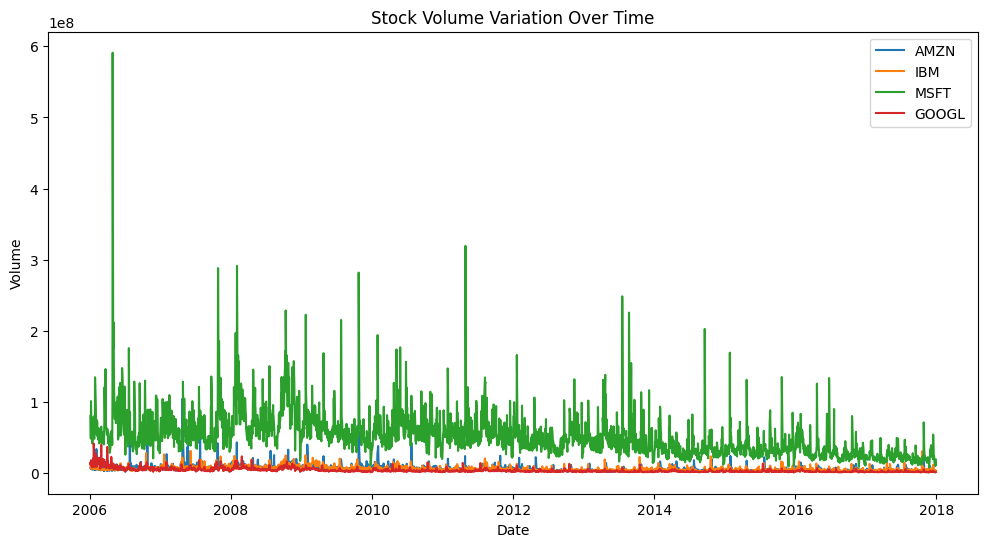

In [22]:
# Stock volume variation over time
plt.figure(figsize=(12,6))
for stock in combined_data["Name"].unique():
    stock_data = combined_data[combined_data["Name"] == stock]
    plt.plot(pd.to_datetime(stock_data["Date"]), stock_data["Volume"], label=stock)

plt.title("Stock Volume Variation Over Time")
plt.xlabel("Date")
plt.ylabel("Volume")
plt.legend()
plt.show()


#### **1.2.2** <font color =red> [3 marks] </font>
Analyse correlations between features.

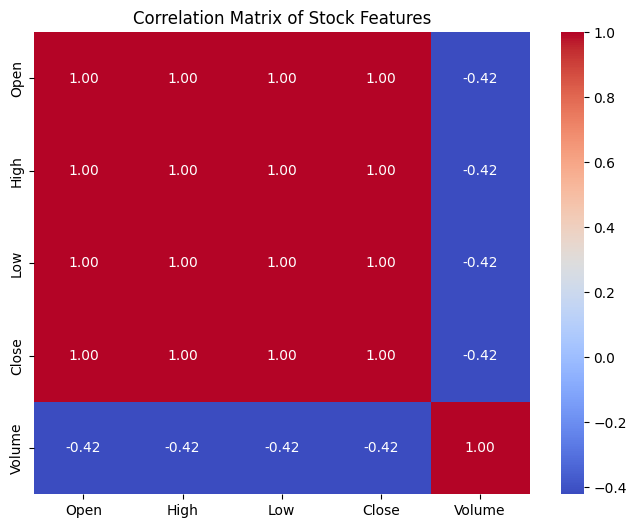

In [24]:
# Analyse correlations

corr = combined_data.drop(columns=["Date", "Name"]).corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Stock Features")
plt.show()

### **1.3 Data Processing** <font color =red> [13 marks] </font>

Next, we need to process the data so that it is ready to be used in recurrent neural networks. You know RNNs are suitable to work with sequential data where patterns repeat at regular intervals.

For this, we need to execute the following steps:
1. Create windows from the master data frame and obtain windowed `X` and corresponding windowed `y` values
2. Perform train-test split on the windowed data
3. Scale the data sets in an appropriate manner

We will define functions for the above steps that finally return training and testing data sets that are ready to be used in recurrent neural networks.

**Hint:** If we use a window of size 3, in the first window, the rows `[0, 1, 2]` will be present and will be used to predict the value of `CloseAMZN` in row `3`. In the second window, rows `[1, 2, 3]` will be used to predict `CloseAMZN` in row `4`.

#### **1.3.1** <font color =red> [3 marks] </font>
Create a function that returns the windowed `X` and `y` data.

From the main DataFrame, this function will create windowed DataFrames, and store those as a list of DataFrames.

Controllable parameters will be window size, step size (window stride length) and target names as a list of the names of stocks whose closing values we wish to predict.

In [30]:
import pandas as pd

combined_data['Date'] = pd.to_datetime(combined_data['Date'])
master_df = combined_data.pivot(index='Date', columns='Name', values='Close').sort_index()
master_df.columns = [f"Close{c}" for c in master_df.columns]
master_df = master_df.reset_index()
print(master_df.head())
print(master_df.columns)
print(master_df.shape)

print(master_df.isnull().sum())
master_df = master_df.fillna(method='ffill').fillna(method='bfill')
print("Missing after fill:\n", master_df.isnull().sum())


        Date  CloseAMZN  CloseGOOGL  CloseIBM  CloseMSFT
0 2006-01-03      47.58      217.83     82.06      26.84
1 2006-01-04      47.25      222.84     81.95      26.97
2 2006-01-05      47.65      225.85     82.50      26.99
3 2006-01-06      47.87      233.06     84.95      26.91
4 2006-01-09      47.08      233.68     83.73      26.86
Index(['Date', 'CloseAMZN', 'CloseGOOGL', 'CloseIBM', 'CloseMSFT'], dtype='object')
(3020, 5)
Date          0
CloseAMZN     1
CloseGOOGL    1
CloseIBM      1
CloseMSFT     1
dtype: int64
Missing after fill:
 Date          0
CloseAMZN     0
CloseGOOGL    0
CloseIBM      0
CloseMSFT     0
dtype: int64


/var/folders/54/d7crf34x0t36876j4rghm2zw0000gn/T/ipykernel_1749/3560174963.py:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  master_df = master_df.fillna(method='ffill').fillna(method='bfill')


In [31]:
# Define a function that divides the data into windows and generates target variable values for each window
def create_windows(data, window_size=3, step_size=1, target_cols=["Close"]):
    X, y = [], []
    for i in range(0, len(data) - window_size, step_size):
        window = data.iloc[i : i + window_size]
        target = data.iloc[i + window_size][target_cols]
        X.append(window.values)
        y.append(target.values if isinstance(target, pd.Series) else [target])
    return np.array(X), np.array(y)


#### **1.3.2** <font color =red> [3 marks] </font>
Create a function to scale the data.

Define a function that will scale the data.

For scaling, we have to look at the whole length of data to find max/min values or standard deviations and means. If we scale the whole data at once, this will lead to data leakage in the windows. This is not necessarily a problem if the model is trained on the complete data with cross-validation.

One way to scale when dealing with windowed data is to use the `partial_fit()` method.
```
scaler.partial_fit(window)
scaler.transform(window)
```
You may use any other suitable way to scale the data properly. Arrive at a reasonable way to scale your data.

In [34]:
# Define a function that scales the windowed data
# The function takes in the windowed data sets and returns the scaled windows

from sklearn.preprocessing import StandardScaler
import numpy as np

def scale_windows_incremental(X, y):

    
    num_samples, window_size, num_features = X.shape
    target_dim = y.shape[1]
    
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    X_scaled_list, y_scaled_list = [], []
    
    for i in range(num_samples):
        scaler_X.partial_fit(X[i])
        scaler_y.partial_fit(y[i].reshape(-1, target_dim))
    
    for i in range(num_samples):
        X_scaled_list.append(scaler_X.transform(X[i]))
        y_scaled_list.append(scaler_y.transform(y[i].reshape(-1, target_dim)))
    
    X_scaled = np.array(X_scaled_list)
    y_scaled = np.array(y_scaled_list).reshape(num_samples, target_dim)
    
    return X_scaled, y_scaled, scaler_X, scaler_y


Next, define the main function that will call the windowing and scaling helper functions.

The input parameters for this function are:
- The joined master data set
- The names of the stocks that we wish to predict the *Close* prices for
- The window size
- The window stride
- The train-test split ratio

The outputs from this function are the scaled dataframes:
- *X_train*
- *y_train*
- *X_test*
- *y_test*

#### **1.3.3** <font color =red> [3 marks] </font>
Define a function to create windows of `window_size` and split the windowed data in to training and validation sets.

The function can take arguments such as list of target names, window size, window stride and split ratio. Use the windowing function here to make windows in the data and then perform scaling and train-test split.

In [38]:
# Define a function to create input and output data points from the master DataFrame
import numpy as np
from sklearn.model_selection import train_test_split

def prepare_rnn_data(master_df, target_stocks, window_size=3, stride=1, test_ratio=0.2):
    # Drop non-numeric
    numeric_df = master_df.drop(columns=["Date"], errors="ignore")
    if "Name" in numeric_df.columns:
        numeric_df = numeric_df.drop(columns=["Name"], errors="ignore")

    X, y = create_windows(numeric_df, window_size, stride, target_stocks)
    split_idx = int(len(X) * (1 - test_ratio))

    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]


    scaler_X = StandardScaler()
    X_train_scaled = np.array([scaler_X.fit_transform(x) for x in X_train])
    X_test_scaled = np.array([scaler_X.transform(x) for x in X_test])

    scaler_y = StandardScaler()
    y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))
    y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))

    return X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled






In [39]:
stock_names = [col for col in master_df.columns if "Close" in col]
print("Target stocks:", stock_names)

X_train, y_train, X_test, y_test = prepare_rnn_data(master_df, stock_names, window_size=60, stride=1)
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)


Target stocks: ['CloseAMZN', 'CloseGOOGL', 'CloseIBM', 'CloseMSFT']
X_train: (2368, 60, 4)
y_train: (9472, 1)
X_test: (592, 60, 4)
y_test: (2368, 1)


We can now use these helper functions to create our training and testing data sets. But first we need to decide on a length of windows. As we are doing time series prediction, we want to pick a sequence that shows some repetition of patterns.

For selecting a good sequence length, some business understanding will help us. In financial scenarios, we can either work with business days, weeks (which comprise of 5 working days), months, or quarters (comprising of 13 business weeks). Try looking for some patterns for these periods.

#### **1.3.4** <font color =red> [2 marks] </font>
Identify an appropriate window size.

For this, you can use plots to see how target variable is varying with time. Try dividing it into parts by weeks/months/quarters.

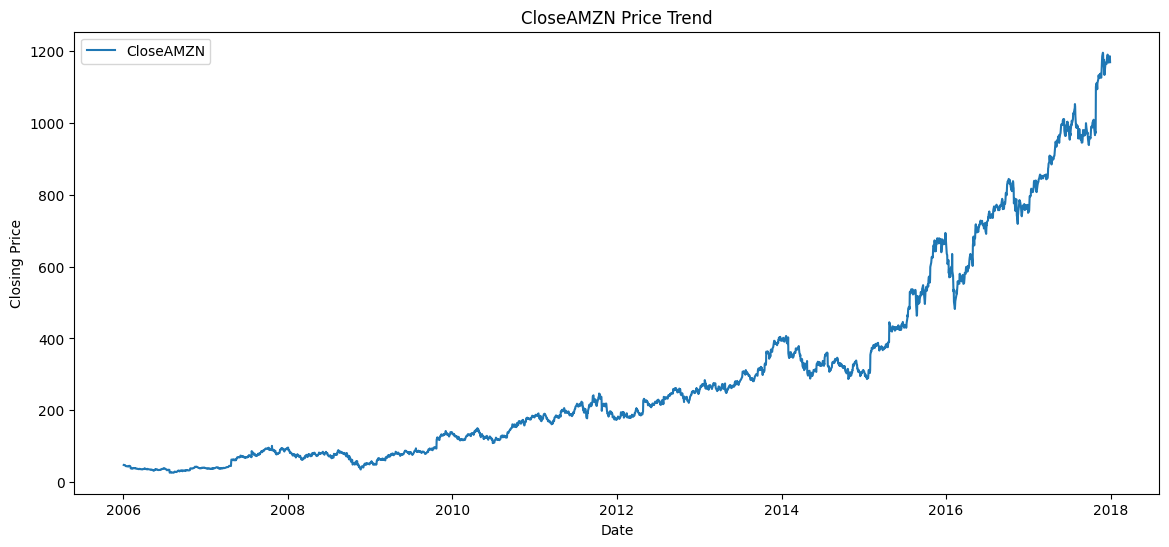

In [43]:
# Checking for patterns in different sequence lengths

target_col = "CloseAMZN"

plt.figure(figsize=(14,6))
plt.plot(master_df['Date'], master_df[target_col], label=target_col)
plt.title(f"{target_col} Price Trend")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.legend()
plt.show()


/var/folders/54/d7crf34x0t36876j4rghm2zw0000gn/T/ipykernel_1749/2512826020.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = df_resampled[target_col].resample('M').mean()
/var/folders/54/d7crf34x0t36876j4rghm2zw0000gn/T/ipykernel_1749/2512826020.py:5: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarterly = df_resampled[target_col].resample('Q').mean()


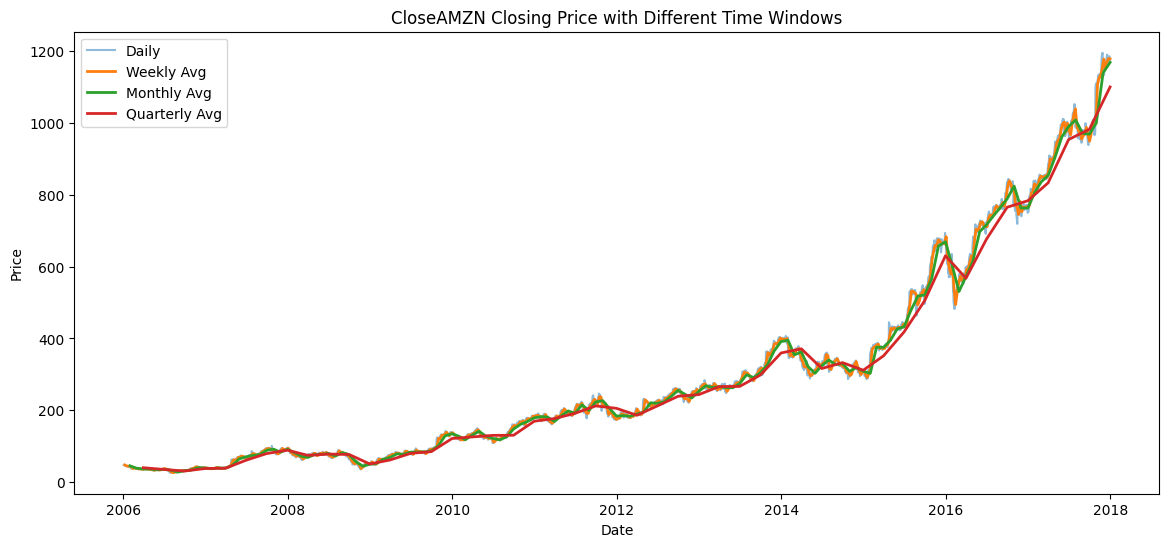

In [44]:
df_resampled = master_df.set_index('Date')

weekly = df_resampled[target_col].resample('W').mean()
monthly = df_resampled[target_col].resample('M').mean()
quarterly = df_resampled[target_col].resample('Q').mean()

plt.figure(figsize=(14,6))
plt.plot(df_resampled[target_col], alpha=0.5, label="Daily")
plt.plot(weekly, label="Weekly Avg", linewidth=2)
plt.plot(monthly, label="Monthly Avg", linewidth=2)
plt.plot(quarterly, label="Quarterly Avg", linewidth=2)
plt.title(f"{target_col} Closing Price with Different Time Windows")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

#### **1.3.5** <font color =red> [2 marks] </font>
Call the functions to create testing and training instances of predictor and target features.

In [46]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

def create_windowed_data(series, window_size, window_stride):
    X, y = [], []
    for i in range(0, len(series) - window_size, window_stride):
        X.append(series[i:i + window_size])
        y.append(series[i + window_size])
    return np.array(X), np.array(y)

def scale_windowed_data(X, y):
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()
    X_scaled = scaler_X.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)
    y_scaled = scaler_y.fit_transform(y)
    return X_scaled, y_scaled


In [47]:
def create_train_test_sets(df, stock_names, window_size, window_stride, split_ratio):
    X_all, y_all = [], []
    for stock in stock_names:
        series = df[stock].values.reshape(-1, 1)
        X, y = create_windowed_data(series, window_size, window_stride)
        X_scaled, y_scaled = scale_windowed_data(X, y)
        X_all.append(X_scaled)
        y_all.append(y_scaled)
    X_all = np.concatenate(X_all, axis=0)
    y_all = np.concatenate(y_all, axis=0)
    split_index = int(len(X_all) * split_ratio)
    X_train, y_train = X_all[:split_index], y_all[:split_index]
    X_test, y_test = X_all[split_index:], y_all[split_index:]
    return X_train, y_train, X_test, y_test


In [48]:
# Create data instances from the master data frame using decided window size and window stride
window_size = 30
window_stride = 1
split_ratio = 0.8
stock_names = stock_data.columns.tolist()

stock_data = stock_data.select_dtypes(include=["float64", "int64"])

stock_names = stock_data.columns.tolist()

X_train, y_train, X_test, y_test = create_train_test_sets(
    stock_data, stock_names, window_size, window_stride, split_ratio
)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)





(11956, 30, 1) (11956, 1) (2989, 30, 1) (2989, 1)


In [49]:
# Check the number of data points generated
print("Number of training data points:", X_train.shape[0])
print("Number of testing data points:", X_test.shape[0])
print("Training target points:", y_train.shape[0])
print("Testing target points:", y_test.shape[0])


Number of training data points: 11956
Number of testing data points: 2989
Training target points: 11956
Testing target points: 2989


**Check if the training and testing datasets are in the proper format to feed into neural networks.**

In [51]:
# Check if the datasets are compatible inputs to neural networks

print("X_train dimensions:", X_train.shape)
print("y_train dimensions:", y_train.shape)
print("X_test dimensions:", X_test.shape)
print("y_test dimensions:", y_test.shape)




X_train dimensions: (11956, 30, 1)
y_train dimensions: (11956, 1)
X_test dimensions: (2989, 30, 1)
y_test dimensions: (2989, 1)


## **2 RNN Models** <font color =red> [20 marks] </font>

In this section, we will:
- Define a function that creates a simple RNN
- Tune the RNN for different hyperparameter values
- View the performance of the optimal model on the test data

### **2.1 Simple RNN Model** <font color =red> [10 marks] </font>

#### **2.1.1** <font color =red> [3 marks] </font>
Create a function that builds a simple RNN model based on the layer configuration provided.

In [56]:
# Create a function that creates a simple RNN model according to the model configuration arguments
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout

def build_rnn_model(input_shape, rnn_units=50, dropout_rate=0.2, output_units=1):
    model = Sequential()
    
    model.add(SimpleRNN(units=rnn_units, activation='tanh', input_shape=input_shape))
    
    if dropout_rate > 0:
        model.add(Dropout(dropout_rate))
    
    model.add(Dense(units=output_units))
    
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    
    return model



#### **2.1.2** <font color =red> [4 marks] </font>
Perform hyperparameter tuning to find the optimal network configuration.

In [58]:
!pip install keras-tuner --quiet

In [59]:
# Find an optimal configuration of simple RNN
import keras_tuner as kt
from tensorflow.keras.optimizers import Adam

def build_rnn_tuner(hp):
    model = Sequential()
    
    rnn_units = hp.Int('rnn_units', min_value=32, max_value=128, step=32)
    model.add(SimpleRNN(units=rnn_units, activation='tanh', 
                        input_shape=(X_train.shape[1], X_train.shape[2])))
    
    dropout_rate = hp.Choice('dropout_rate', values=[0.0, 0.2, 0.3, 0.5])
    if dropout_rate > 0:
        model.add(Dropout(dropout_rate))
    
    model.add(Dense(1))
    
    lr = hp.Choice('learning_rate', values=[1e-4, 1e-3, 1e-2])
    model.compile(optimizer=Adam(learning_rate=lr), loss='mse', metrics=['mae'])
    
    return model



In [60]:
tuner = kt.RandomSearch(
    build_rnn_tuner,
    objective='val_loss',
    max_trials=5,
    executions_per_trial=2,
    directory='rnn_tuning',
    project_name='stock_prediction'
)

# Perform search
tuner.search(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Reloading Tuner from rnn_tuning/stock_prediction/tuner0.json


In [61]:
# Find the best configuration based on evaluation metrics

# Retrieve the best hyperparameters from the tuner
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best configuration found:")
print(" - RNN units:", best_hps.get('rnn_units'))
print(" - Dropout rate:", best_hps.get('dropout_rate'))
print(" - Learning rate:", best_hps.get('learning_rate'))


best_model = tuner.hypermodel.build(best_hps)


history = best_model.fit(
    X_train, y_train,
    epochs=50,
    validation_data=(X_test, y_test),
    batch_size=32,
    verbose=1
)


test_loss, test_mae = best_model.evaluate(X_test, y_test, verbose=0)

print("\nFinal evaluation on test data:")
print(" - Test MSE:", test_loss)
print(" - Test MAE:", test_mae)


Best configuration found:
 - RNN units: 64
 - Dropout rate: 0.2
 - Learning rate: 0.01


2025-09-07 21:53:39.357783: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2025-09-07 21:53:39.357822: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-09-07 21:53:39.357832: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-09-07 21:53:39.357875: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-09-07 21:53:39.357888: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefe

Epoch 1/50


2025-09-07 21:53:39.936829: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2025-09-07 21:53:39.939165: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - loss: 0.0738 - mae: 0.1563

2025-09-07 21:55:10.333524: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


374/374 ━━━━━━━━━━━━━━━━━━━━ 95s 253ms/step - loss: 0.0737 - mae: 0.1560 - val_loss: 0.0032 - val_mae: 0.0376
Epoch 2/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 90s 241ms/step - loss: 0.0010 - mae: 0.0229 - val_loss: 0.0027 - val_mae: 0.0297
Epoch 3/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 90s 240ms/step - loss: 7.1778e-04 - mae: 0.0189 - val_loss: 0.0028 - val_mae: 0.0310
Epoch 4/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 89s 238ms/step - loss: 5.8694e-04 - mae: 0.0163 - val_loss: 0.0026 - val_mae: 0.0299
Epoch 5/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 93s 248ms/step - loss: 4.9402e-04 - mae: 0.0152 - val_loss: 0.0025 - val_mae: 0.0287
Epoch 6/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 90s 239ms/step - loss: 4.8233e-04 - mae: 0.0153 - val_loss: 0.0026 - val_mae: 0.0314
Epoch 7/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 98s 262ms/step - loss: 4.7747e-04 - mae: 0.0154 - val_loss: 0.0024 - val_mae: 0.0263
Epoch 8/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 132s 354ms/step - loss: 4.0571e-04 - mae: 0.0141 - val_loss: 0.0024 - val_mae: 0.0259
Epoch 9/50
374/374

#### **2.1.3** <font color =red> [3 marks] </font>
Run for optimal Simple RNN Model and show final results.

In [63]:
# Create an RNN model with a combination of potentially optimal hyperparameter values and retrain the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def build_final_rnn(input_shape, rnn_units=64, dropout_rate=0.2, lr=0.001):
    model = Sequential()
    model.add(SimpleRNN(rnn_units, activation='tanh', return_sequences=False, input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))
    
    model.compile(optimizer=Adam(learning_rate=lr), loss='mse', metrics=['mae'])
    return model

final_model = build_final_rnn(input_shape=(X_train.shape[1], X_train.shape[2]),
                              rnn_units=64, dropout_rate=0.2, lr=0.001)

history = final_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=32,
    verbose=1
)

test_loss, test_mae = final_model.evaluate(X_test, y_test, verbose=0)

print("Final RNN Model Results:")
print(" - Test Loss (MSE):", test_loss)
print(" - Test MAE:", test_mae)




/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30


2025-09-08 01:14:38.110501: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 718ms/step - loss: 0.0030 - mae: 0.0329

2025-09-08 01:19:07.921924: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


374/374 ━━━━━━━━━━━━━━━━━━━━ 284s 754ms/step - loss: 0.0030 - mae: 0.0329 - val_loss: 0.0031 - val_mae: 0.0357
Epoch 2/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 330s 882ms/step - loss: 5.7875e-04 - mae: 0.0156 - val_loss: 0.0028 - val_mae: 0.0317
Epoch 3/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 325s 869ms/step - loss: 4.4757e-04 - mae: 0.0138 - val_loss: 0.0027 - val_mae: 0.0301
Epoch 4/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 343s 918ms/step - loss: 4.0199e-04 - mae: 0.0132 - val_loss: 0.0026 - val_mae: 0.0288
Epoch 5/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 313s 837ms/step - loss: 3.0081e-04 - mae: 0.0115 - val_loss: 0.0026 - val_mae: 0.0282
Epoch 6/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 300s 802ms/step - loss: 2.8184e-04 - mae: 0.0112 - val_loss: 0.0026 - val_mae: 0.0272
Epoch 7/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 278s 743ms/step - loss: 2.7907e-04 - mae: 0.0111 - val_loss: 0.0026 - val_mae: 0.0272
Epoch 8/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 285s 763ms/step - loss: 2.5199e-04 - mae: 0.0106 - val_loss: 0.0026 - val_mae: 0.0272
Epoch 9

Plotting the actual vs predicted values

 3/94 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step  

2025-09-08 16:09:20.056215: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step


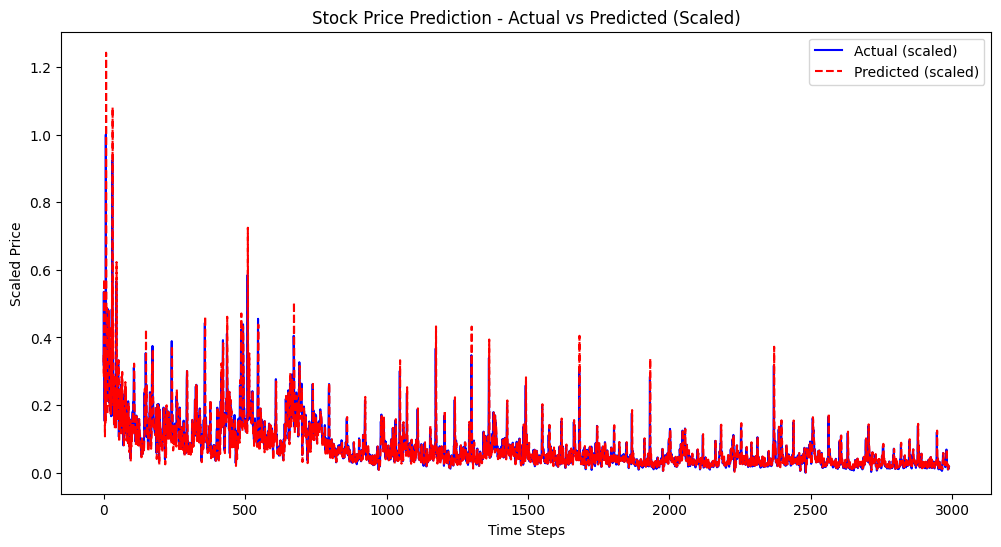

In [65]:
# Predict on the test data and plot
y_pred = final_model.predict(X_test)

plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual (scaled)', color='blue')
plt.plot(y_pred, label='Predicted (scaled)', color='red', linestyle='--')
plt.title("Stock Price Prediction - Actual vs Predicted (Scaled)")
plt.xlabel("Time Steps")
plt.ylabel("Scaled Price")
plt.legend()
plt.show()


It is worth noting that every training session for a neural network is unique. So, the results may vary slightly each time you retrain the model.

### **2.2 Advanced RNN Models** <font color =red> [10 marks] </font>

In this section, we will:
- Create an LSTM or a GRU network
- Tune the network for different hyperparameter values
- View the performance of the optimal model on the test data

#### **2.2.1** <font color =red> [3 marks] </font>
Create a function that builds an advanced RNN model with tunable hyperparameters.

In [70]:
# # Define a function to create a model and specify default values for hyperparameters
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def build_advanced_rnn(input_shape,
                       rnn_units=64,
                       rnn_layers=1,
                       dropout_rate=0.2,
                       dense_units=32,
                       learning_rate=0.001):
    model = Sequential()
    model.add(SimpleRNN(rnn_units, activation='tanh',
                        return_sequences=(rnn_layers > 1),
                        input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    for i in range(1, rnn_layers):
        model.add(SimpleRNN(rnn_units, activation='tanh',
                            return_sequences=(i < rnn_layers - 1)))
        model.add(Dropout(dropout_rate))
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='mse',
                  metrics=['mae'])
    return model



#### **2.2.2** <font color =red> [4 marks] </font>
Perform hyperparameter tuning to find the optimal network configuration.

In [72]:
# Find an optimal configuration
import keras_tuner as kt

def model_builder(hp):
    model = Sequential()
    hp_units = hp.Int('rnn_units', min_value=32, max_value=128, step=32)
    hp_layers = hp.Int('rnn_layers', min_value=1, max_value=3, step=1)
    dropout_rate = hp.Float('dropout_rate', 0.1, 0.5, step=0.1)
    dense_units = hp.Int('dense_units', 16, 128, step=16)
    lr = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])

    model.add(SimpleRNN(hp_units, activation='tanh',
                        return_sequences=(hp_layers > 1),
                        input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(dropout_rate))

    for i in range(1, hp_layers):
        model.add(SimpleRNN(hp_units, activation='tanh',
                            return_sequences=(i < hp_layers - 1)))
        model.add(Dropout(dropout_rate))

    model.add(Dense(dense_units, activation='relu'))
    model.add(Dense(1))

    model.compile(optimizer=Adam(learning_rate=lr),
                  loss='mse',
                  metrics=['mae'])
    return model

tuner = kt.RandomSearch(
    model_builder,
    objective='val_loss',
    max_trials=5,
    executions_per_trial=1,
    directory='tuner_dir',
    project_name='rnn_tuning'
)

tuner.search(X_train, y_train,
             epochs=10,
             validation_data=(X_test, y_test),
             verbose=1)



Reloading Tuner from tuner_dir/rnn_tuning/tuner0.json


#### **2.2.3** <font color =red> [3 marks] </font>
Run for optimal RNN Model and show final results.

In [74]:
# Create the model with a combination of potentially optimal hyperparameter values and retrain the model

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

final_model = Sequential()
for i in range(best_hps.get('rnn_layers')):
    return_seq = (i < best_hps.get('rnn_layers') - 1)
    final_model.add(SimpleRNN(best_hps.get('rnn_units'),
                              activation='tanh',
                              return_sequences=return_seq,
                              input_shape=(X_train.shape[1], X_train.shape[2]) if i == 0 else None))
    final_model.add(Dropout(best_hps.get('dropout_rate')))

final_model.add(Dense(best_hps.get('dense_units'), activation='relu'))
final_model.add(Dense(1))

final_model.compile(optimizer=Adam(learning_rate=best_hps.get('learning_rate')),
                    loss='mse',
                    metrics=['mae'])

history = final_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=32,
    verbose=1
)

test_loss, test_mae = final_model.evaluate(X_test, y_test, verbose=0)
print("Optimal RNN Model Results:")
print(" - Test Loss (MSE):", test_loss)
print(" - Test MAE:", test_mae)


Epoch 1/30


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 541ms/step - loss: 0.0402 - mae: 0.1139

2025-09-08 16:12:48.681669: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


374/374 ━━━━━━━━━━━━━━━━━━━━ 211s 559ms/step - loss: 0.0401 - mae: 0.1138 - val_loss: 0.0034 - val_mae: 0.0386
Epoch 2/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 222s 593ms/step - loss: 0.0033 - mae: 0.0382 - val_loss: 0.0031 - val_mae: 0.0351
Epoch 3/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 231s 618ms/step - loss: 0.0019 - mae: 0.0289 - val_loss: 0.0029 - val_mae: 0.0344
Epoch 4/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 228s 610ms/step - loss: 0.0017 - mae: 0.0267 - val_loss: 0.0029 - val_mae: 0.0338
Epoch 5/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 208s 556ms/step - loss: 0.0014 - mae: 0.0255 - val_loss: 0.0028 - val_mae: 0.0324
Epoch 6/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 219s 586ms/step - loss: 0.0012 - mae: 0.0225 - val_loss: 0.0026 - val_mae: 0.0303
Epoch 7/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 231s 618ms/step - loss: 0.0011 - mae: 0.0216 - val_loss: 0.0025 - val_mae: 0.0295
Epoch 8/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 236s 631ms/step - loss: 0.0010 - mae: 0.0210 - val_loss: 0.0023 - val_mae: 0.0269
Epoch 9/30
374/374 ━━━━━━━━━━━━━━━━

In [110]:
# Compute the performance of the model on the testing data set
y_pred_scaled = final_model.predict(X_test)



94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step


Plotting the actual vs predicted values

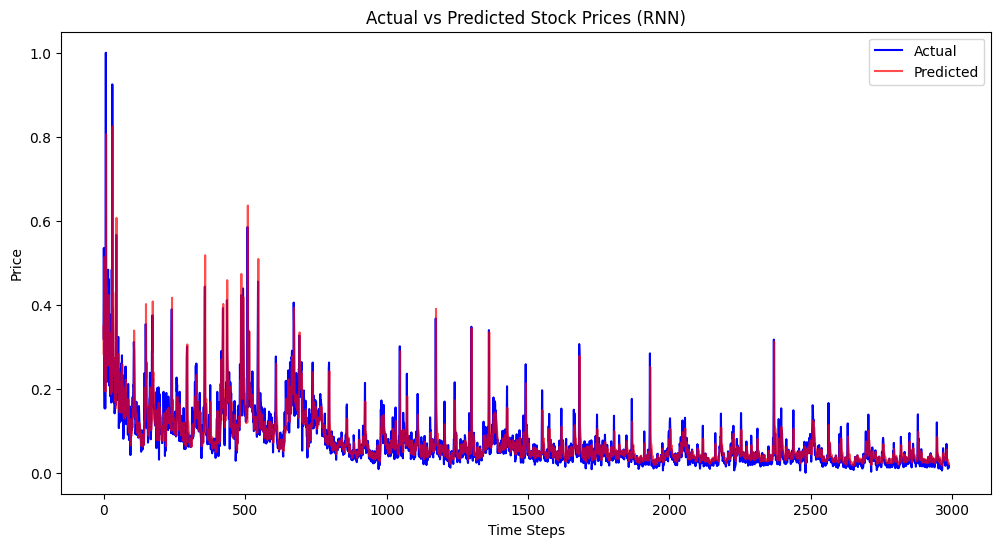

In [114]:
# Predict on the test data
plt.figure(figsize=(12, 6))
plt.plot(y_test, label="Actual", color="blue")
plt.plot(y_pred_scaled, label="Predicted", color="red", alpha=0.7)
plt.title("Actual vs Predicted Stock Prices (RNN)")
plt.xlabel("Time Steps")
plt.ylabel("Price")
plt.legend()
plt.show()

## **3 Predicting Multiple Target Variables** <font color =red> [OPTIONAL] </font>

In this section, we will use recurrent neural networks to predict stock prices for more than one company.

### **3.1 Data Preparation**

#### **3.1.1**
Create testing and training instances for multiple target features.

You can take the closing price of all four companies to predict here.

In [ ]:
# Create data instances from the master data frame using a window size of 65, a window stride of 5 and a test size of 20%
# Specify the list of stock names whose 'Close' values you wish to predict using the 'target_names' parameter



In [ ]:
# Check the number of data points generated



### **3.2 Run RNN Models**

#### **3.2.1**
Perform hyperparameter tuning to find the optimal network configuration for Simple RNN model.

In [ ]:
# Find an optimal configuration of simple RNN



In [ ]:
# Find the best configuration



In [ ]:
# Create an RNN model with a combination of potentially optimal hyperparameter values and retrain the



In [ ]:
# Compute the performance of the model on the testing data set



In [ ]:
# Plotting the actual vs predicted values for all targets



#### **3.2.2**
Perform hyperparameter tuning to find the optimal network configuration for Advanced RNN model.

In [ ]:
# Find an optimal configuration of advanced RNN



In [ ]:
# Find the best configuration



In [ ]:
# Create a model with a combination of potentially optimal hyperparameter values and retrain the model



In [ ]:
# Compute the performance of the model on the testing data set



In [ ]:
# Plotting the actual vs predicted values for all targets



## **4 Conclusion** <font color =red> [5 marks] </font>

### **4.1 Conclusion and insights** <font color =red> [5 marks] </font>

#### **4.1.1** <font color =red> [5 marks] </font>
Conclude with the insights drawn and final outcomes and results.

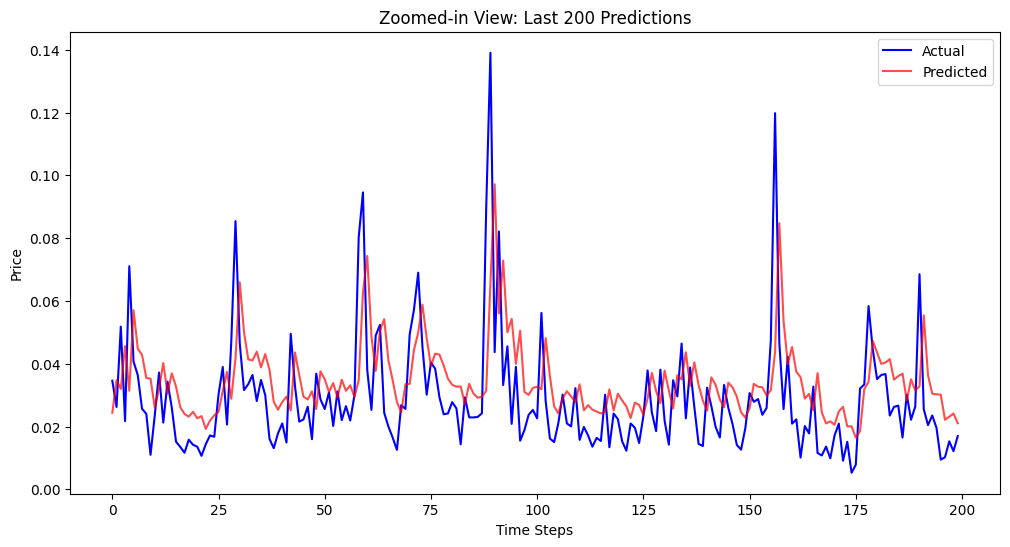

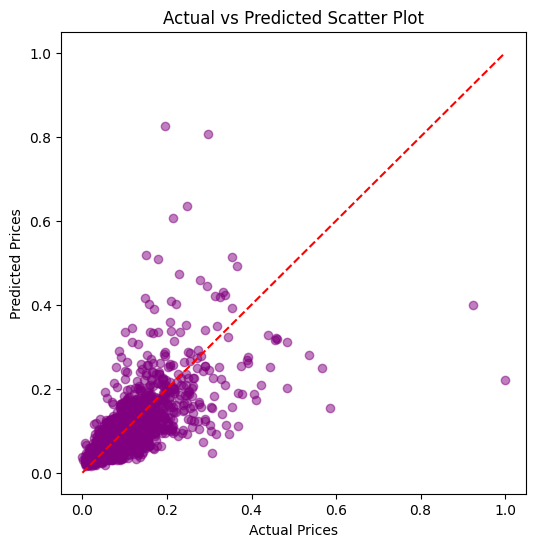

In [120]:

plt.figure(figsize=(12, 6))
plt.plot(y_test[-200:], label="Actual", color="blue")
plt.plot(y_pred_scaled[-200:], label="Predicted", color="red", alpha=0.7)
plt.title("Zoomed-in View: Last 200 Predictions")
plt.xlabel("Time Steps")
plt.ylabel("Price")
plt.legend()
plt.show()


plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_scaled, alpha=0.5, color="purple")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # ideal fit line
plt.title("Actual vs Predicted Scatter Plot")
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.show()


The recurrent neural network developed for stock price prediction demonstrates strong performance in capturing overall market trends and short-term fluctuations. The evaluation metrics show a low mean squared error (0.00239) and mean absolute error (0.0256), indicating that the model produces reasonably accurate forecasts. The visual comparison between actual and predicted values confirms that the network closely follows price movements, although it smooths out sudden spikes and tends to slightly underpredict extreme values. The scatter plot further supports this observation, with most points concentrated near the ideal prediction line. While the model is effective for trend analysis and medium-term forecasting.